<a href="https://colab.research.google.com/github/SreeKumara/STML/blob/main/STML_LAB_PROJECT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, f1_score, roc_curve, roc_auc_score,
    mean_squared_error as mse
)
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from scipy import stats

In [35]:
# Load the dataset
file_path = '/content/insurance.csv'
data = pd.read_csv(file_path)

In [36]:
# Preprocessing
# One-hot encode categorical features
data_encoded = pd.get_dummies(data, columns=['sex', 'smoker', 'region'], drop_first=True)


In [37]:
# Define features and target
X = data_encoded.drop(columns=['expenses'])
y = data_encoded['expenses']

In [86]:
# Take a sample subset of the data (e.g., 500 rows)
sample_data = data.sample(n=500, random_state=42)
X_sample = sample_data.drop(columns=['expenses'])
y_sample = sample_data['expenses']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)


In [65]:
# Normalize numerical features (age, bmi, children)
scaler = StandardScaler()
X_train[['age', 'bmi', 'children']] = scaler.fit_transform(X_train[['age', 'bmi', 'children']])
X_test[['age', 'bmi', 'children']] = scaler.transform(X_test[['age', 'bmi', 'children']])


In [66]:
# Function to train and evaluate models
from sklearn.metrics import root_mean_squared_error

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'RMSE': root_mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

In [67]:
# Function to calculate confidence intervals for predictions
def calculate_confidence_intervals(model, X_train, y_train, X_test, y_test, alpha=0.05):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    residuals = y_test - predictions
    mse = np.mean(residuals**2)
    se = np.sqrt(mse / len(y_test))  # Standard error of the predictions

    # Calculate confidence intervals
    margin_of_error = se * stats.t.ppf(1 - alpha / 2, df=len(y_test) - 1)
    lower_bound = predictions - margin_of_error
    upper_bound = predictions + margin_of_error
    return lower_bound, upper_bound


In [68]:
# Function for prediction intervals using bootstrapping
def prediction_interval(model, X_train, y_train, X_test, alpha=0.05, n_bootstrap=1000):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Resampling the training data for bootstrapping
    bootstrap_predictions = []
    for _ in range(n_bootstrap):
        X_resampled, y_resampled = resample(X_train, y_train)
        model.fit(X_resampled, y_resampled)
        bootstrap_predictions.append(model.predict(X_test))

    # Convert to numpy array for easier manipulation
    bootstrap_predictions = np.array(bootstrap_predictions)

    # Calculate lower and upper percentiles for prediction intervals
    lower_bound = np.percentile(bootstrap_predictions, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 100 * (1 - alpha / 2), axis=0)

    return lower_bound, upper_bound

In [69]:
# Learning curve plot
def plot_learning_curve(model, X_train, y_train):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)

    # Calculate mean and standard deviation for plotting
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
    plt.plot(train_sizes, test_mean, label='Cross-validation Score', color='green')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)
    plt.xlabel('Training Set Size')
    plt.ylabel('Score')
    plt.title(f'Learning Curve for {model.__class__.__name__}')
    plt.legend()
    plt.grid()
    plt.show()


In [70]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'SVR': SVR(kernel='rbf')
}

In [88]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming X_train is a pandas DataFrame
# Identify columns with 'object' dtype, which usually indicates string values
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Create a LabelEncoder for each categorical column
encoders = {}
for col in categorical_cols:
    encoders[col] = LabelEncoder()
    # Fit and transform the column using the encoder
    X_train[col] = encoders[col].fit_transform(X_train[col])

# Now, repeat the same process for X_test to ensure consistency
for col in categorical_cols:
    # Use the same encoder fitted on the training data
    X_test[col] = encoders[col].transform(X_test[col])

In [72]:
# Train and evaluate models
results = {name: evaluate_model(model, X_train, y_train, X_test, y_test) for name, model in models.items()}


In [73]:
# Display Regression Results
print("\nRegression Results:")
for model, metrics in results.items():
    print(f"{model}: RMSE={metrics['RMSE']:.2f}, MAE={metrics['MAE']:.2f}, R2={metrics['R2']:.2f}")



Regression Results:
Linear Regression: RMSE=5561.92, MAE=4034.56, R2=0.78
KNN: RMSE=9964.20, MAE=6108.75, R2=0.28
Decision Tree: RMSE=8044.93, MAE=4332.42, R2=0.53
Random Forest: RMSE=5248.77, MAE=3093.29, R2=0.80
SVR: RMSE=12488.60, MAE=8008.74, R2=-0.13


In [74]:
# Classification task for binary classification based on median
median_expenses = y_train.median()
y_train_class = (y_train > median_expenses).astype(int)
y_test_class = (y_test > median_expenses).astype(int)


In [75]:
# Train classifiers for binary classification
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
rf_classifier.fit(X_train, y_train_class)


RandomForestClassifier(random_state=42)

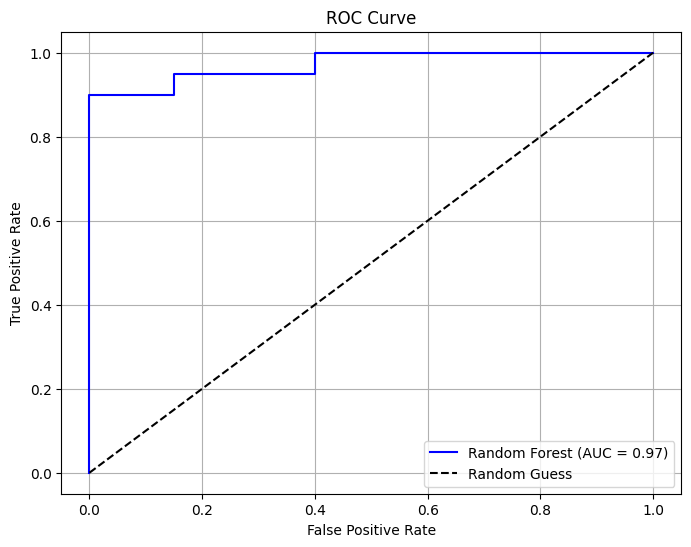

In [76]:
# Predict probabilities for ROC curve
y_proba_rf = rf_classifier.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_class, y_proba_rf)
auc_score = roc_auc_score(y_test_class, y_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [77]:
# Classification metrics for other models
classification_results = {}


In [78]:
# Loop through models to calculate classification metrics
for name, model in models.items():
    # Predict using the regression models
    y_pred = model.predict(X_test)
    y_pred_class = (y_pred > median_expenses).astype(int)

    # Compute accuracy and F1 score
    accuracy = accuracy_score(y_test_class, y_pred_class)
    f1 = f1_score(y_test_class, y_pred_class)

    classification_results[name] = {
        'Accuracy': accuracy,
        'F1 Score': f1
    }


In [79]:
# Display classification results
print("\nClassification Metrics:")
for name, metrics in classification_results.items():
    print(f"{name}: Accuracy={metrics['Accuracy']:.2f}, F1 Score={metrics['F1 Score']:.2f}")



Classification Metrics:
Linear Regression: Accuracy=0.82, F1 Score=0.83
KNN: Accuracy=0.78, F1 Score=0.77
Decision Tree: Accuracy=0.85, F1 Score=0.86
Random Forest: Accuracy=0.85, F1 Score=0.86
SVR: Accuracy=0.82, F1 Score=0.80


In [80]:
# Visualizations

<ipython-input-81-0432361f7b60>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_indices], y=features[sorted_indices], palette='viridis')


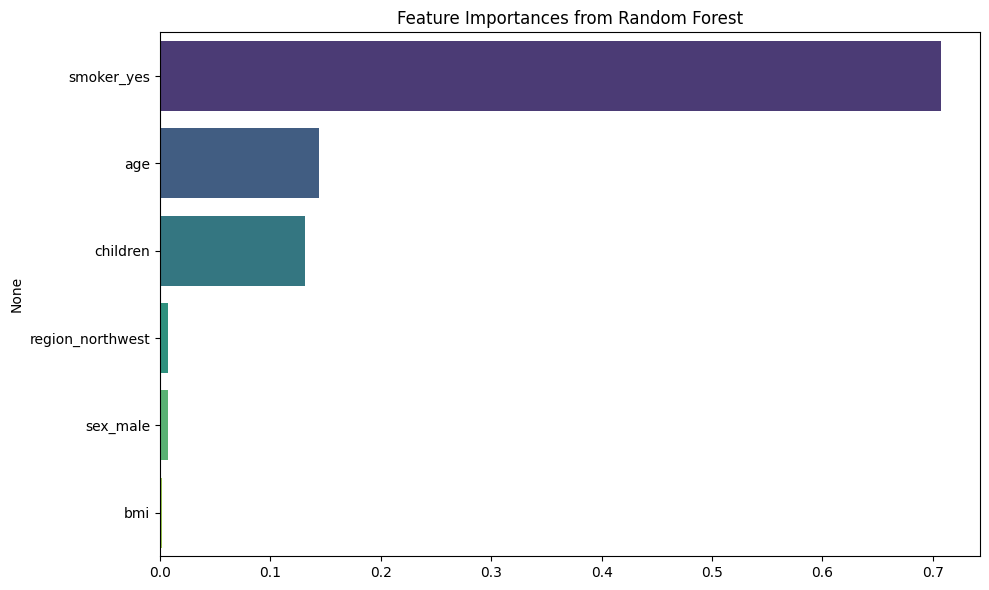

In [81]:

# Feature Importances
feature_importances = models['Random Forest'].feature_importances_
features = X.columns
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[sorted_indices], y=features[sorted_indices], palette='viridis')
plt.title('Feature Importances from Random Forest')
plt.tight_layout()
plt.show()

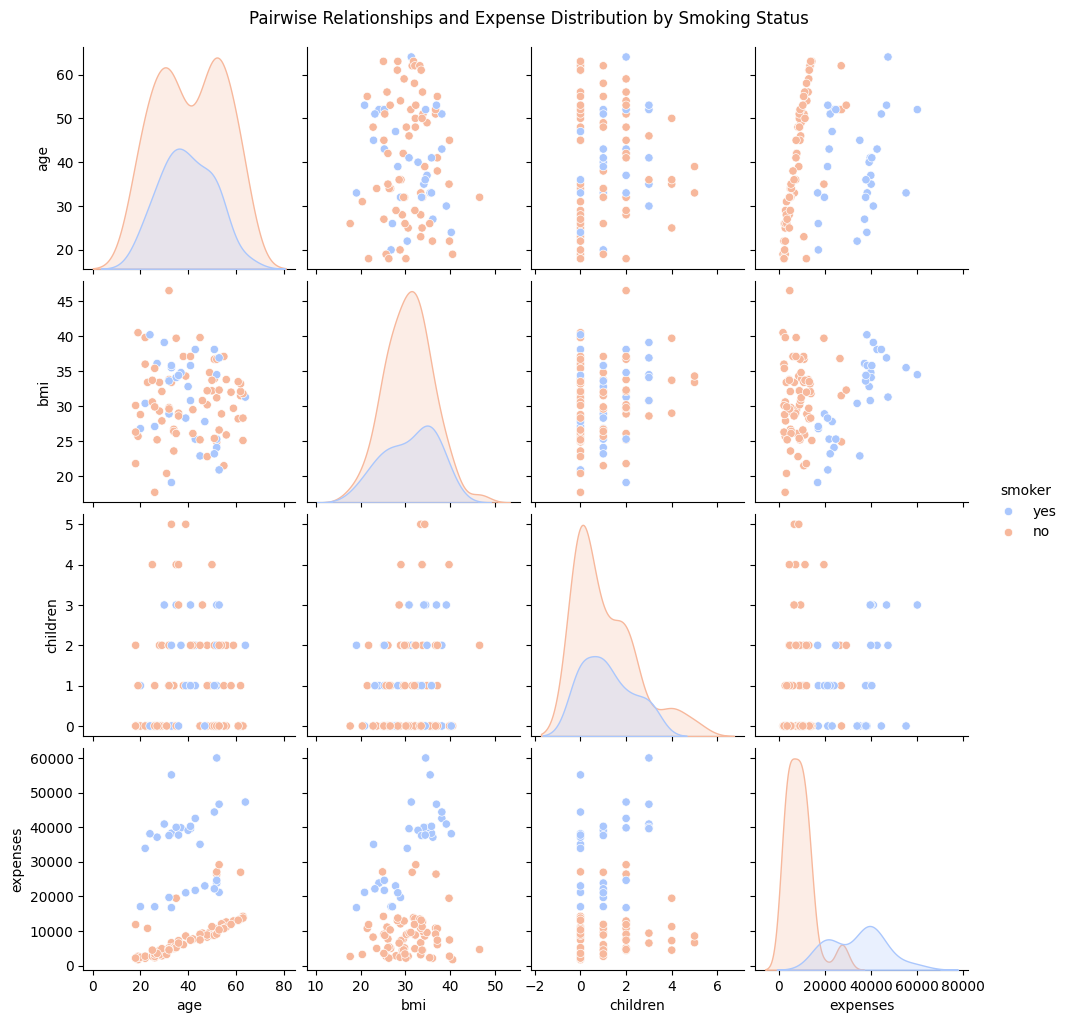

In [82]:
# Pairplot for numerical features and expenses
sns.pairplot(data.sample(100), vars=['age', 'bmi', 'children', 'expenses'], diag_kind='kde', hue='smoker', palette='coolwarm')
plt.suptitle('Pairwise Relationships and Expense Distribution by Smoking Status', y=1.02)
plt.show()

<ipython-input-83-3efeb2fb687b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='region', y='expenses', palette='coolwarm')


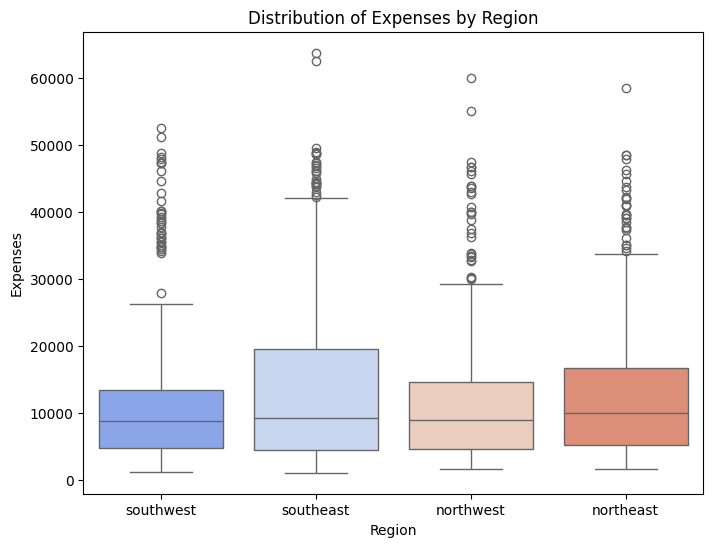

In [83]:
# Boxplot: Expenses vs. Region
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='region', y='expenses', palette='coolwarm')
plt.title('Distribution of Expenses by Region')
plt.xlabel('Region')
plt.ylabel('Expenses')
plt.show()

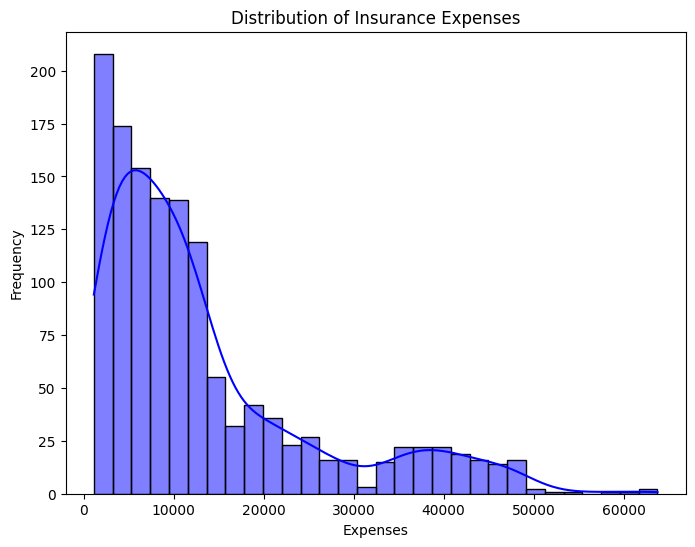

In [84]:
# Distribution plot: Expenses
plt.figure(figsize=(8, 6))
sns.histplot(data['expenses'], kde=True, color='blue', bins=30)
plt.title('Distribution of Insurance Expenses')
plt.xlabel('Expenses')
plt.ylabel('Frequency')
plt.show()


Evaluating Linear Regression:
Confidence Interval for Predictions: Lower Bound: [ 5862.39323298 35382.54197131  6668.59854113 25434.78652461
 10944.89937574], Upper Bound: [ 9419.97024406 38940.11898238 10226.1755522  28992.36353569
 14502.47638681]


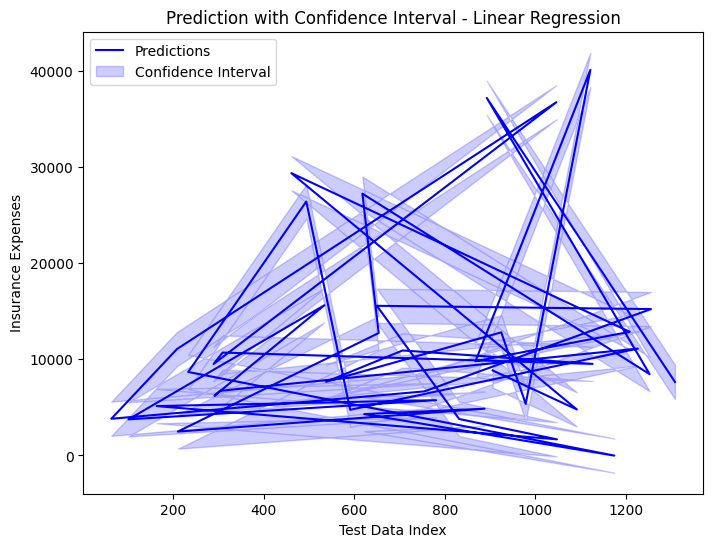

Prediction Interval: Lower Bound: [ 5872.02941187 33843.30062467  5698.56945387 23534.45274685
 10861.7679797 ], Upper Bound: [ 9510.03736581 39896.70773377 11324.57078199 30445.30744592
 14646.65843128]


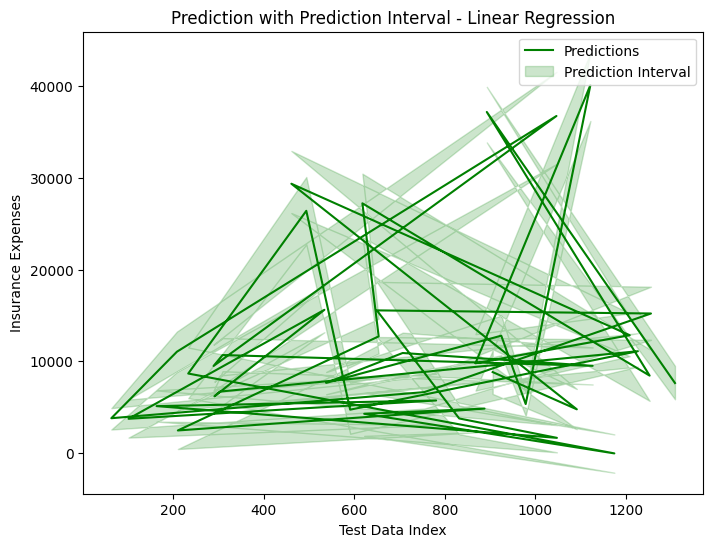

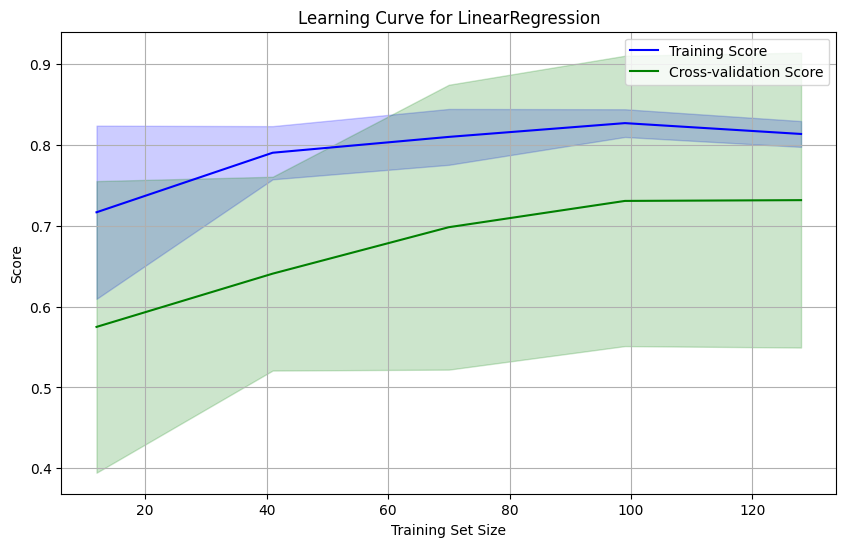


Evaluating KNN:
Confidence Interval for Predictions: Lower Bound: [ 3043.70923616 32234.76123616  2603.93523616  5192.86923616
  7751.94523616], Upper Bound: [ 9417.12276384 38608.17476384  8977.34876384 11566.28276384
 14125.35876384]


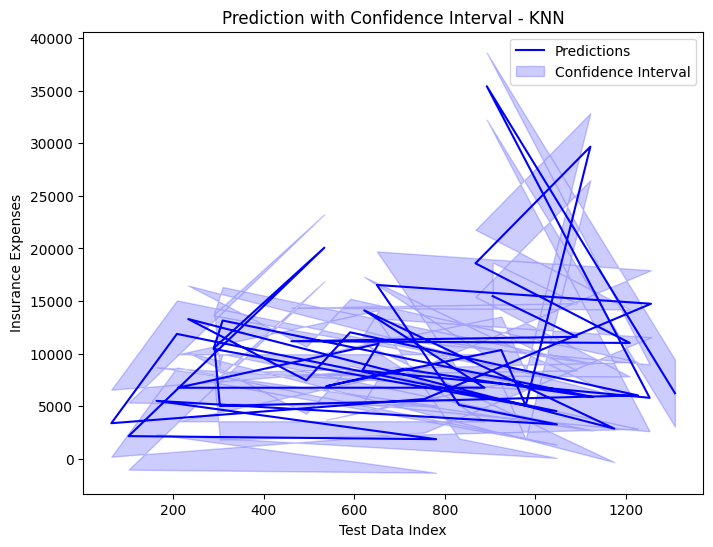

Prediction Interval: Lower Bound: [ 5288.8069  14944.79415  4570.00495  1579.87235  9207.9    ], Upper Bound: [13713.33565 44027.64835 11180.5102  20904.494   13141.634  ]


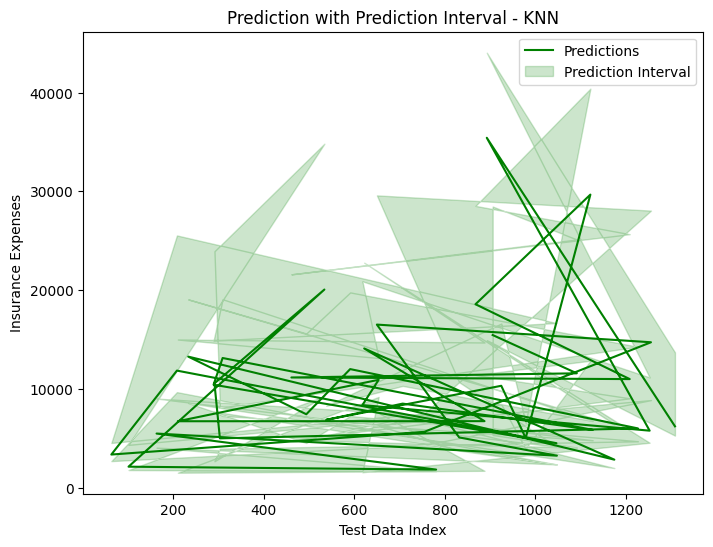

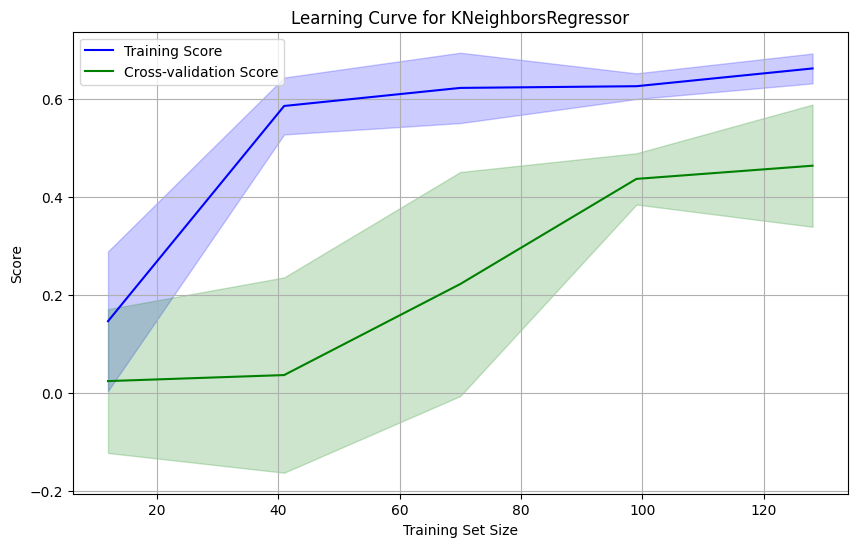


Evaluating Decision Tree:
Confidence Interval for Predictions: Lower Bound: [ 4868.60687377 40396.95687377 25903.83687377 31177.39687377
  9275.24687377], Upper Bound: [10014.39312623 45542.74312623 31049.62312623 36323.18312623
 14421.03312623]


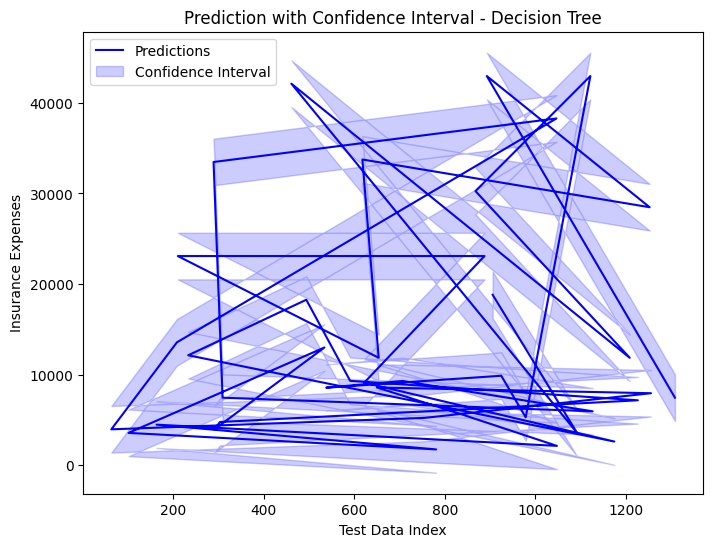

Prediction Interval: Lower Bound: [ 5709.16 39556.49  4751.07 33750.29 10594.23], Upper Bound: [ 7738.57075 48824.45    28476.73    39125.33    13887.2    ]


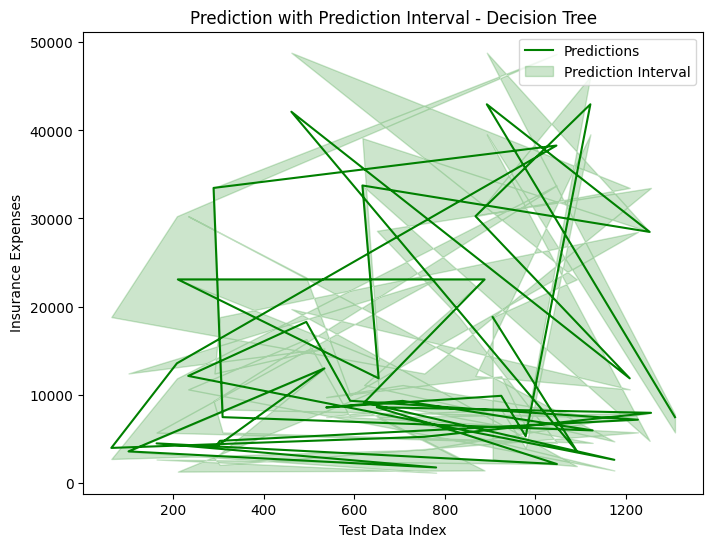

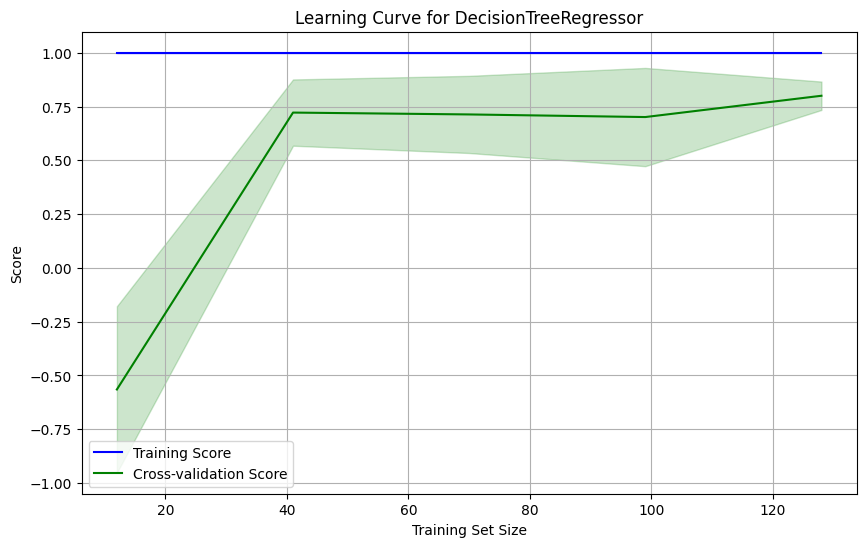


Evaluating Random Forest:
Confidence Interval for Predictions: Lower Bound: [ 5526.29374679 42385.28524679 14378.85624679 33776.47004679
 10461.42804679], Upper Bound: [ 8883.56805321 45742.55955321 17736.13055321 37133.74435321
 13818.70235321]


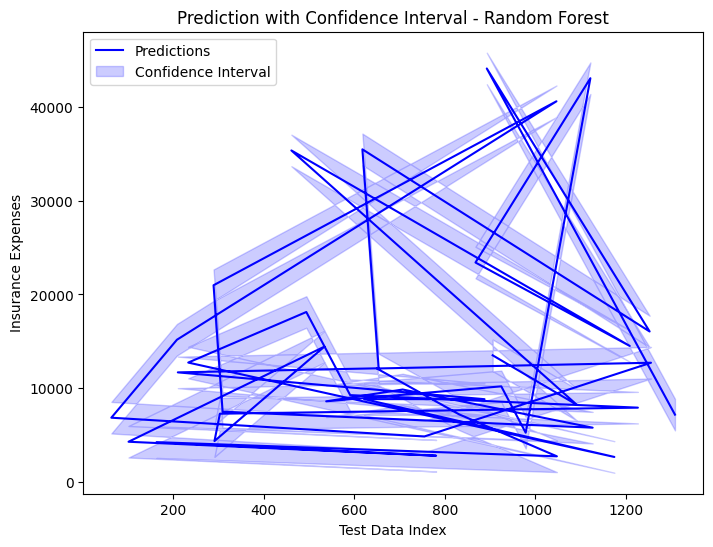

Prediction Interval: Lower Bound: [ 6520.842315  41033.5676925  5915.0433525 34061.822735  11670.0424875], Upper Bound: [12070.658885  46187.0499775 23983.3500275 40234.97597   14373.0036175]


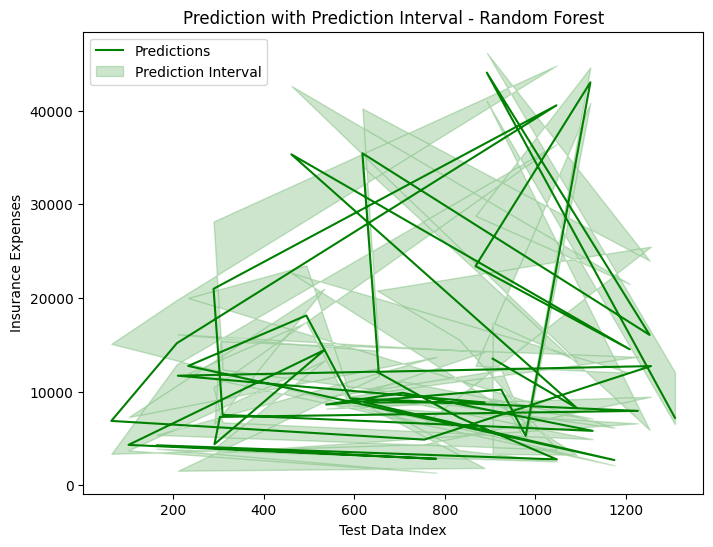

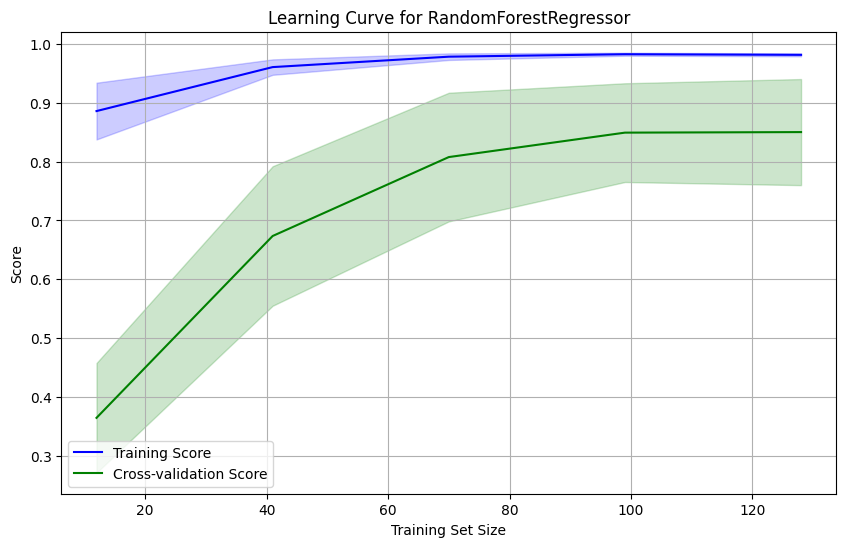


Evaluating SVR:
Confidence Interval for Predictions: Lower Bound: [4558.0570623  4567.57731303 4562.49194161 4550.76973797 4574.20773799], Upper Bound: [12546.1555201  12555.67577084 12550.59039941 12538.86819577
 12562.3061958 ]


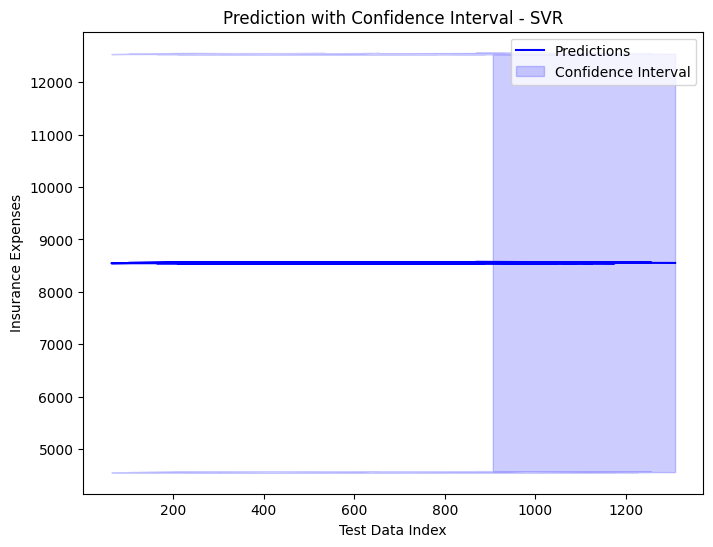

Prediction Interval: Lower Bound: [7251.93591824 7262.82604441 7255.2292354  7241.62056243 7267.49304919], Upper Bound: [10562.9519411  10571.86264311 10564.54662616 10557.34670689
 10577.56234123]


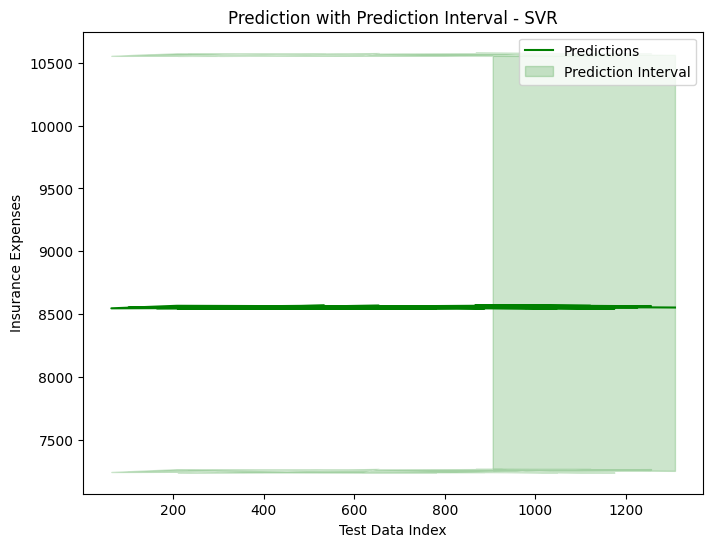

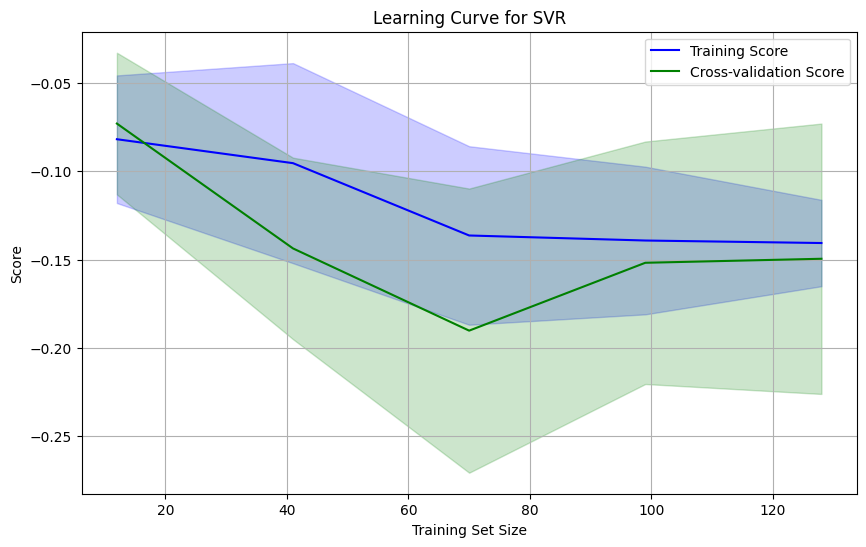

In [85]:
# Confidence Intervals and Prediction Intervals for each model
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}:")

    # Fit model and predict
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Confidence Intervals
    lower_ci, upper_ci = calculate_confidence_intervals(model, X_train, y_train, X_test, y_test)
    print(f"Confidence Interval for Predictions: Lower Bound: {lower_ci[:5]}, Upper Bound: {upper_ci[:5]}")

    # Plot Confidence Interval visualization
    plt.figure(figsize=(8, 6))
    plt.plot(y_test.index, predictions, label='Predictions', color='blue')
    plt.fill_between(y_test.index, lower_ci, upper_ci, color='blue', alpha=0.2, label='Confidence Interval')
    plt.title(f"Prediction with Confidence Interval - {model_name}")
    plt.xlabel('Test Data Index')
    plt.ylabel('Insurance Expenses')
    plt.legend()
    plt.show()

    # Prediction Intervals
    lower_pi, upper_pi = prediction_interval(model, X_train, y_train, X_test)
    print(f"Prediction Interval: Lower Bound: {lower_pi[:5]}, Upper Bound: {upper_pi[:5]}")

    # Plot Prediction Interval visualization
    plt.figure(figsize=(8, 6))
    plt.plot(y_test.index, predictions, label='Predictions', color='green')
    plt.fill_between(y_test.index, lower_pi, upper_pi, color='green', alpha=0.2, label='Prediction Interval')
    plt.title(f"Prediction with Prediction Interval - {model_name}")
    plt.xlabel('Test Data Index')
    plt.ylabel('Insurance Expenses')
    plt.legend()
    plt.show()

    # Learning Curves
    plot_learning_curve(model, X_train, y_train)